In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/malaria.zip" -d "/content/sample_data/Dataset"  

Archive:  /content/drive/My Drive/malaria.zip
   creating: /content/sample_data/Dataset/malaria/
  inflating: /content/sample_data/Dataset/malaria/training.json  
   creating: /content/sample_data/Dataset/__MACOSX/
   creating: /content/sample_data/Dataset/__MACOSX/malaria/
  inflating: /content/sample_data/Dataset/__MACOSX/malaria/._training.json  
   creating: /content/sample_data/Dataset/malaria/images/
  inflating: /content/sample_data/Dataset/malaria/images/027ab174-e47a-44f8-b85b-372449eeb7d8.png  
   creating: /content/sample_data/Dataset/__MACOSX/malaria/images/
  inflating: /content/sample_data/Dataset/__MACOSX/malaria/images/._027ab174-e47a-44f8-b85b-372449eeb7d8.png  
  inflating: /content/sample_data/Dataset/malaria/images/b1145408-feae-4637-b4cf-3e70b99cc62d.png  
  inflating: /content/sample_data/Dataset/__MACOSX/malaria/images/._b1145408-feae-4637-b4cf-3e70b99cc62d.png  
  inflating: /content/sample_data/Dataset/malaria/images/351d6536-3a5c-46eb-a6e4-d71dd999908a.jpg  
 

In [5]:
import os
import json 
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

import cv2 
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image, ImageEnhance

import random

In [6]:


def read_data(file_name, path = "/content/sample_data/Dataset/malaria/"):
  f = open(path+file_name,) 
  data = json.load(f) 
  bounding_b_per_img = []
  image_path = []
  xmax = []
  xmin = []
  ymin = []
  ymax = []
  labels = []
  print('number of data: ',len(data))
  final_data = []
  mydf = pd.DataFrame()
  for img in data:
    for i in img['objects']:
      bb = i['bounding_box']
      image_path.append(img['image']['pathname'])
      xmin.append(bb['minimum']['r'])
      xmax.append(bb['maximum']['r'])
      ymin.append(bb['minimum']['c'])
      ymax.append(bb['maximum']['c'])
      labels.append(i['category'])
  
    bounding_b_per_img.append(len(img['objects']))

    image_dict = dict(image = img['image']['pathname'], shape = img['image']['shape'], bounding_boxes = img['objects'])  
    final_data.append(image_dict)

  mydf['img_path'] = image_path
  mydf['xmin'] = xmin
  mydf['xmax'] = xmax
  mydf['ymin'] = ymin
  mydf['ymax'] =  ymax
  mydf['class'] = labels
  
  
  return final_data, mydf, bounding_b_per_img


train_data, mydf, bounding_b_per_img = read_data('training.json')
test_data, mydf_test, bounding_b_per_img_t = read_data('test.json')




number of data:  1208
number of data:  120


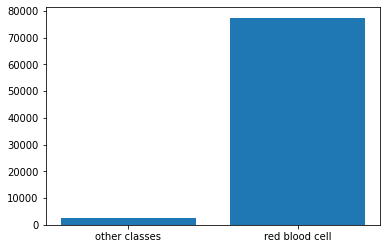

red blood cell    77420
trophozoite        1473
difficult           441
ring                353
schizont            179
gametocyte          144
leukocyte           103
Name: class, dtype: int64


In [7]:

classes = mydf['class']
temp = []
for i in classes:
  if i == "red blood cell":
     temp.append("red blood cell")
  else:
    temp.append("other classes")

labels, counts = np.unique(temp, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

print(mydf['class'].value_counts())


In [8]:
import cv2
import copy
import numpy as np
from numba import jit, cuda 

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

def mask_image(data, mode = "train"):
  healthy = ['leukocyte', 'red blood cell']
  diseased = ['trophozoite', 'ring', 'schizont', 'gametocyte']
  categories= {'leukocyte':1, 'red blood cell':2, 'trophozoite':3, 'ring':4, 'schizont':5, 'difficult':255, 'gametocyte':6}

  train_images_gray_scale = []
  train_images = []
  y_train = []
  path = '/content/sample_data/Dataset/malaria'
  for n, i in enumerate(data):
    img = cv2.imread(path + i['image'])
    new_image = copy.copy(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # apply gussion filter to denoise images
    blur = cv2.GaussianBlur(img,(5,5),0)
    train_images.append(blur)
    
    new_image1 = copy.copy(new_image[:,:,0])
    new_image2 = copy.copy(new_image[:,:,0])
    new_image3 = copy.copy(new_image[:,:,0])
    new_image4 = copy.copy(new_image[:,:,0])
    new_image5 = copy.copy(new_image[:,:,0])
    new_image6 = copy.copy(new_image[:,:,0])
    new_image7 = copy.copy(new_image[:,:,0])
    new_image1[:,:] = 255
    new_image2[:,:] = 255
    new_image3[:,:] = 255
    new_image4[:,:] = 255
    new_image5[:,:] = 255
    new_image6[:,:] = 255
    new_image7[:,:] = 0

    for bb in i['bounding_boxes'] :
      bounding = bb['bounding_box'] 
      min_val = bounding['minimum']
      max_val = bounding['maximum']
      if bb["category"] != "difficult":
        new_image7[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = 255
      if bb["category"] in healthy:
        if bb["category"] == 'leukocyte' :
          new_image1[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = 0
        if bb["category"] == 'red blood cell' :
          new_image2[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = 0
      if bb["category"] in diseased:
        if bb["category"] == 'trophozoite' :
          new_image3[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = 0
        if bb["category"] == 'ring' :
          new_image4[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = 0
        if bb["category"] == 'schizont' :
          new_image5[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = 0
        if bb["category"] == 'gametocyte' :
          new_image6[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = 0
          
    
    new_image1 = resize(new_image1, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    new_image2 = resize(new_image2, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    new_image3 = resize(new_image3, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    new_image4 = resize(new_image4, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    new_image5 = resize(new_image5, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    new_image6 = resize(new_image6, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    new_image7 = resize(new_image7, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    label = np.ones((IMG_HEIGHT, IMG_WIDTH, 7))
    label[:,:,0] = new_image1.astype(np.uint8)
    label[:,:,1] = new_image2.astype(np.uint8)
    label[:,:,2] = new_image3.astype(np.uint8)
    label[:,:,3] = new_image4.astype(np.uint8)
    label[:,:,4] = new_image5.astype(np.uint8)
    label[:,:,5] = new_image6.astype(np.uint8)
    label[:,:,6] = new_image7.astype(np.uint8)
    
  
    y_train.append(label)
    if n % 100 == 0:
      print("====> done: ", n)
   
  return  train_images, y_train


print("number of train images: ",len(train_data))
print("number of test images: ",len(test_data))

X_train, y_train = mask_image(train_data)
X_test, y_test = mask_image(test_data,"test")

print(len(y_train))


number of train images:  1208
number of test images:  120
====> done:  0
====> done:  100
====> done:  200
====> done:  300
====> done:  400
====> done:  500
====> done:  600
====> done:  700
====> done:  800
====> done:  900
====> done:  1000
====> done:  1100
====> done:  1200
====> done:  0
====> done:  100
1208


In [9]:
import  sklearn

X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.array([i.astype(np.uint8) for i in X_train])
X_test = np.array([i.astype(np.uint8) for i in X_test])


In [113]:
#enhance images
def enahnced_img(imgs, factor):
  enahanced_X = []
  for i in imgs:
    im = Image.fromarray(i.astype(np.uint8))
    enhancer = ImageEnhance.Contrast(im)
    im_output = enhancer.enhance(factor)
    enahanced_X.append(im_output)
  return enahanced_X

enhanced_X_train = [np.array(i) for i in enahnced_img(X_train, 1.1)]
enhanced_X_test = [np.array(i) for i in enahnced_img(X_test, 2.2)]

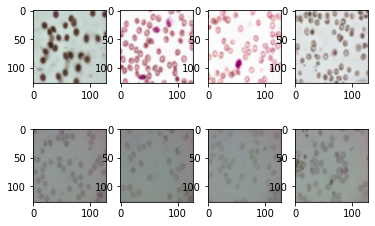

In [11]:
def draw_fig(images):
  fig, axes = plt.subplots(2,4)
  axes[0,0].imshow(images[0])
  axes[0,1].imshow(images[1])
  axes[0,2].imshow(images[2])
  axes[0,3].imshow(images[3])
  axes[1,0].imshow(images[4])
  axes[1,1].imshow(images[5])
  axes[1,2].imshow(images[6])
  axes[1,3].imshow(images[7])

index = [random.randint(0,1200) for _ in range(4)]
index_t = [random.randint(0,110) for _ in range(4)]
         
img = [X_train[i] for i in index]
img_t = [X_test[i] for i in index_t]
draw_fig(img + img_t)

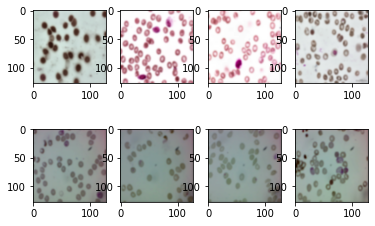

In [12]:
img = [enhanced_X_train[i] for i in index]
img_t = [enhanced_X_test[i] for i in index_t]
draw_fig(img + img_t)

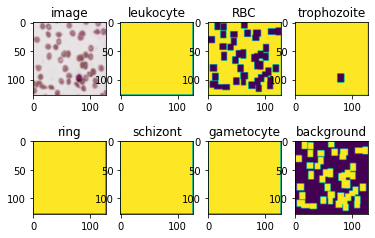

In [13]:

fig, axes = plt.subplots(2,4)
axes[0,0].imshow(X_train[223])
axes[0,1].imshow(y_train[223][:,:,0])
axes[0,2].imshow(y_train[223][:,:,1])
axes[0,3].imshow(y_train[223][:,:,2])
axes[1,0].imshow(y_train[223][:,:,3])
axes[1,1].imshow(y_train[223][:,:,4])
axes[1,2].imshow(y_train[223][:,:,5])
axes[1,3].imshow(y_train[223][:,:,6])
axes[0,0].title.set_text('image')
axes[0,1].title.set_text('leukocyte')
axes[0,2].title.set_text('RBC')
axes[0,3].title.set_text('trophozoite')
axes[1,0].title.set_text('ring')
axes[1,1].title.set_text('schizont')
axes[1,2].title.set_text('gametocyte')
axes[1,3].title.set_text('background')

In [144]:
import keras
def get_model():

  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = Lambda(lambda x: x / 255) (inputs)

  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(7, (1, 1), activation='sigmoid') (c9)

  model = keras.Model(inputs, outputs)
  return model


model = get_model()
model.summary()


Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 128, 128, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 128, 128, 16) 448         lambda_6[0][0]                   
__________________________________________________________________________________________________
dropout_54 (Dropout)            (None, 128, 128, 16) 0           conv2d_114[0][0]                 
______________________________________________________________________________________

In [145]:
import time

iou_value = []

def IoU(y_true, y_pred):
  y_true = tf.keras.backend.eval(y_true)
  y_pred = tf.keras.backend.eval(y_pred)
  iou = []
  for i in range(7):
    y_pred_f = y_pred[:,:,i].flat
    y_true_f = y_true[:,:,i].flat
    intersection = sum(np.multiply(y_true_f, y_pred_f))
    union = sum(y_true_f) + sum(y_pred_f) 
    iou.append(intersection / union)
  
  return sum(iou)/7
  

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics = [IoU], run_eagerly=True)


In [162]:
t1 = time.time()
history = model.fit(np.array(enhanced_X_train), y_train, batch_size=64 , epochs = 10)
t2 = time.time()
print("training time: ", t2 -t1)
metric = history.history['IoU']

# plt.plot([i for i in range(115)],metric)
# plt.xlabel("Epoches")
# plt.ylabel("IoU")
# plt.title("Train IoU")


Epoch 1/10
19/19 [==============================] - 8s 443ms/step - loss: 2758.9280 - IoU: 0.9676
Epoch 2/10
19/19 [==============================] - 9s 447ms/step - loss: 2758.7842 - IoU: 0.9681
Epoch 3/10
19/19 [==============================] - 9s 450ms/step - loss: 2758.6606 - IoU: 0.9689
Epoch 4/10
19/19 [==============================] - 9s 449ms/step - loss: 2758.6626 - IoU: 0.9693
Epoch 5/10
19/19 [==============================] - 9s 450ms/step - loss: 2758.5266 - IoU: 0.9700
Epoch 6/10
19/19 [==============================] - 9s 450ms/step - loss: 2758.4917 - IoU: 0.9699
Epoch 7/10
19/19 [==============================] - 8s 447ms/step - loss: 2758.4067 - IoU: 0.9700
Epoch 8/10
19/19 [==============================] - 8s 444ms/step - loss: 2758.3882 - IoU: 0.9706
Epoch 9/10
19/19 [==============================] - 8s 439ms/step - loss: 2758.2339 - IoU: 0.9711
Epoch 10/10
19/19 [==============================] - 8s 441ms/step - loss: 2758.3142 - IoU: 0.9717
training time:  89.

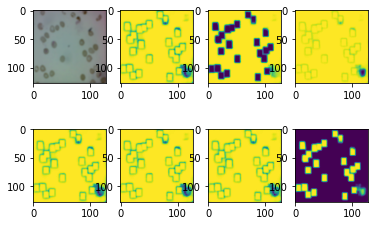

In [167]:

y_pred = model.predict(np.array(enhanced_X_test))
img = [enhanced_X_test[8]]
for i in range(7):
    img.append(y_pred[8][:,:,i])

img_ = [enhanced_X_test[8]]
for i in range(7):
    img_.append(y_test[8][:,:,i])

draw_fig(img)


# ret,thresh1 = cv2.threshold(y_pred[223][:,:,6],0.5,255,cv2.THRESH_BINARY)
# plt.imshow(thresh1.astype(np.uint8))
# print(thresh1)
# print(y_train[223][:,:,0])



In [179]:
def IoU_pred(y_true, y_pred, c):
  y_true = tf.keras.backend.eval(y_true)
  y_pred = tf.keras.backend.eval(y_pred)
  iou = []
  s = 0
  # print(np.array(y_pred).shape)
  # print(np.array(y_true).shape)
  for y_predd, y_truee in zip(y_pred, y_true):
    ss = 0
    for i in range(7):
      if i == 0 or i == 1:
        y_pred_f = y_predd[:,:,i].flat
        y_true_f = y_truee[:,:,i].flat
        intersection = sum(np.multiply(y_true_f, y_pred_f))
        union = sum(y_true_f) + sum(y_pred_f) 
        ss+= intersection / union
      
    s+=ss/2
    
  return s/120

In [180]:
iou = IoU_pred(y_test, y_pred, 0)

In [181]:
print(iou)

0.9479496635282877
